In [1]:
import sys
import os
import requests

import torch
import numpy as np
import matplotlib.pyplot as plt

import models_cross
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from BRAVOData import BRAVOData

In [3]:
transforms_train_n_eval = transforms.Compose([
                                    transforms.Lambda(lambda x: x.permute(2, 0, 1)),
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize(mean=[3.0892, 1.6437, 1.3494, 
                                                               0.9318, 1.0241, 0.6993,
                                                               0.7459, 0.7565],
                                                         std=[4.4823, 2.6962, 2.1895,
                                                              1.4849, 1.6206, 1.1844,
                                                              1.1394, 1.1681])
                                    ])
    
dataset_eval = BRAVOData('dataset/train', transforms_x=transforms_train_n_eval, mode = 'eval')
print("The length of the dataset is: {}".format(len(dataset_eval)))

The length of the dataset is: 10


In [122]:
model = models_cross.__dict__['mae_vit_small_patch16'](
        norm_pix_loss=True, weight_fm=True, 
        decoder_depth=12, use_input=True,
        self_attn=False, img_size=224)

checkpoint = torch.load("pretrained_weights/checkpoint-400.pth", map_location = 'cpu')
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]

# load pre-trained model
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)
model.eval()

use self attention:  False
<All keys matched successfully>


MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(8, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

In [123]:
img_cl, img_corrupt = dataset_eval[5]

In [124]:
def show_image(image_data):

    # Creating a 4x2 subplot to show each band
    fig, axes = plt.subplots(2, 4)    
    for i, ax in enumerate(axes.flat):
        ax.imshow(image_data[i], cmap='gray')
        ax.set_title(f"Channel {i + 1}")
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


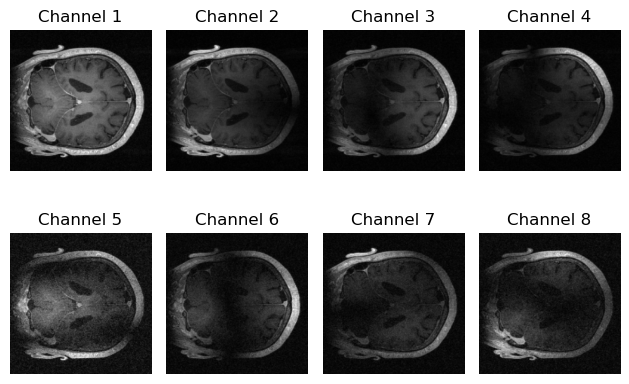

In [125]:
show_image(img_cl)

In [126]:
if img_cl.dim() == 3:
    img_cl = img_cl.unsqueeze(0)

if img_corrupt.dim() == 3:
    img_corrupt = img_corrupt.unsqueeze(0)

In [135]:
#pass either img_cl or img_corrupt
with torch.no_grad():
    loss, pred, mask  = model.forward(img_cl, 0.75, 1.0, True)
pred = model.unpatchify(pred)
pred = pred.squeeze(0)

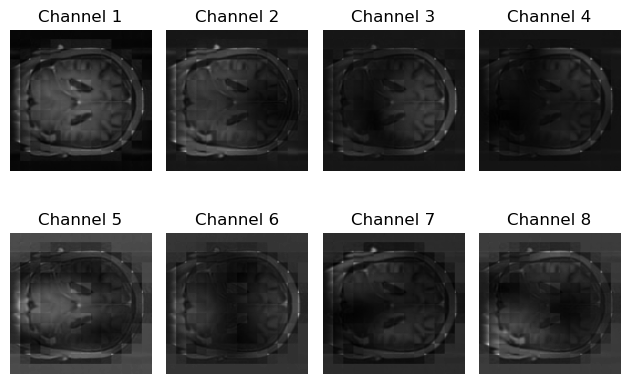

In [136]:
show_image(pred)